In [31]:
import networkExpansionPy.lib as ne
import numpy as np
import pandas as pd
import pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests
plt.rcParams['font.family'] = 'Arial'

import json

def read_json_to_dict(filename):
    with open(filename, 'r') as f:
        dictionary = json.load(f)
    return dictionary


import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

def load_data(network_name):
    with open(ne.asset_path  + "/metabolic_networks/" + network_name,"rb") as filehandler:
        metabolism = pickle.load(filehandler)
    return metabolism

# load the metabolism object from the repo
#metabolism = load_data('metabolism.23Aug2022.pkl')
#model_id = "metabolism.v4.20Mar2023.pkl"
model_id = "metabolism.v8.01May2023.pkl"
metabolism = pd.read_pickle('/Users/joshuagoldford/Documents/github/network-expansion-assets/models/' + model_id)
cids = metabolism.coenzymes

In [32]:
seed = pd.read_csv('../assets/seed_set.csv')

seed_set = seed['ID'].tolist() #+ ["C00183"]
#seed_df = pd.read_csv('assets/seed_set.csv')
#seed_set = seed_df[~seed_df.Type.isin(["Organic carbon"])].ID.tolist()
#seed_set = seed_set + ["C00010"]

print('There were {N} compounds in this seed set...'.format(N=len(seed_set)))

ne_cpds,ne_rxns = metabolism.expand(seed_set,algorithm='trace')
print('There were {N} compounds produced in this expansion!'.format(N=len(ne_cpds)))

# parse data into dataframes
rn_df = pd.DataFrame(pd.Series(ne_rxns),columns = ['iteration'])
rn_df.reset_index(inplace=True)
rn_df.columns = ['rn','direction','iteration']
rn_df['rn_kegg']= rn_df['rn'].apply(lambda x: x.split('_')[0])

abun = pd.DataFrame(pd.Series(ne_cpds),columns=['iter']).reset_index().groupby('iter').count()
abun['compounds (cumulative)'] = abun['index'].cumsum()

There were 70 compounds in this seed set...
There were 4315 compounds produced in this expansion!


In [33]:
rxn_dicts = read_json_to_dict("data/reaction_taxonomy_specificty.json")

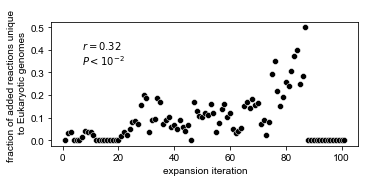

In [44]:
rn_df["euk_rxns"] = rn_df["rn_kegg"].apply(lambda x: x in rxn_dicts["eukaryote_specific"])
rn_df["c"] = 1
rn_df_c = rn_df.groupby("iteration").sum()
rn_df_c["f_euks"]=rn_df_c["euk_rxns"] / rn_df_c["c"]
plt.figure(figsize=(5.5,4/14*8))
rn_df_c = rn_df_c.reset_index()
sns.scatterplot(x="iteration",y="f_euks",data=rn_df_c,color="k")
plt.xlabel("expansion iteration")
plt.ylabel("fraction of added reactions unique \n to Eukaryotic genomes")


r,pval = pearsonr(rn_df_c['iteration'].values,rn_df_c["f_euks"].values)
d = int(np.ceil(np.log10(pval)))
label = '$r={R}$ \n'.format(R=round(r,2)) + '$P<10^{' + str(d) + '}$'
plt.annotate(label, xy=(0.1, 0.65), xycoords='axes fraction')

plt.savefig("figs/si_fig_euk_enrichment.svg")

In [35]:
morg = metabolism.copy()
metabolism.network = metabolism.network[~metabolism.network.rn_old.isin(rxn_dicts["eukaryote_specific"])]

ne_cpds_e,ne_rxns_e = metabolism.expand(seed_set,algorithm='trace')
print('There were {N} compounds produced in this expansion!'.format(N=len(ne_cpds_e)))


There were 3806 compounds produced in this expansion!


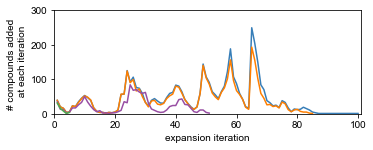

In [60]:
# now remove purine production 
metab_unmod = metabolism.copy()
ne_cpds_e, ne_rxns_e = metab_unmod.expand(seed_set,algorithm='trace')
rn_to_remove = [x for x in metab_unmod.network.rn.unique().tolist() if (('_gATP' in x) or ('_gGTP' in x))]
metab_unmod.network = metab_unmod.network[~metab_unmod.network.rn.isin(rn_to_remove)]
ne_cpds_np,ne_rxns_np = metab_unmod.expand(seed_set,algorithm='trace')

metab_p = morg.copy()
metab_p.network = metab_p.network[~metab_p.network.rn_old.isin(rxn_dicts["prokaryote_specific"])]
ne_cpds_p,ne_rxns_p = metab_p.expand(seed_set,algorithm='trace')


metab_s = morg.copy()
metab_s.network = metab_s.network[~metab_s.network.rn_old.isin(rxn_dicts["shared"])]
ne_cpds_s,ne_rxns_s = metab_s.expand(seed_set,algorithm='trace')

cmap = sns.color_palette("Set1")

abun_alt = pd.DataFrame(pd.Series(ne_cpds_np),columns=['iter']).reset_index().groupby('iter').count()
abun_alt['compounds (cumulative)'] = abun_alt['index'].cumsum()

abun_ad = pd.DataFrame(pd.Series(ne_cpds_e),columns=['iter']).reset_index().groupby('iter').count()
abun_ad['compounds (cumulative)'] = abun_ad['index'].cumsum()

abun_s= pd.DataFrame(pd.Series(ne_cpds_s),columns=['iter']).reset_index().groupby('iter').count()
abun_s['compounds (cumulative)'] = abun_s['index'].cumsum()

abun_p= pd.DataFrame(pd.Series(ne_cpds_p),columns=['iter']).reset_index().groupby('iter').count()
abun_p['compounds (cumulative)'] = abun_p['index'].cumsum()


#sns.scatterplot(x='iter',y='compounds (cumulative)',data=abun)
#plt.figure(figsize=(8,4/14*8))

plt.figure(figsize=(5.5,4/14*8))

sns.lineplot(x='iter',y='index',data=abun.iloc[1:],color=cmap[1])
sns.lineplot(x='iter',y='index',data=abun_ad.iloc[1:],color=cmap[4])
sns.lineplot(x='iter',y='index',data=abun_p.iloc[1:],color=cmap[3])
sns.lineplot(x='iter',y='index',data=abun_s.iloc[1:],color=cmap[2])


#sns.lineplot(x='iter',y='index',data=abun_alt.iloc[1:],color="k")

plt.ylabel('# compounds added \n at each iteration')
plt.xlabel("expansion iteration")
plt.xlim([0,101])
plt.ylim([0,300])
plt.subplots_adjust(bottom=0.25)
#plt.legend(['Unmodified + adenine','Modified','Unmodified'])
plt.savefig("figs/si_fig_domain_specific.svg")

In [78]:
abun_ad

,index,compounds (cumulative)
iter,,
0,67,67
1,39,106
2,20,126
3,16,142
4,4,146
...,...,...
81,7,3793
82,5,3798
83,5,3803


In [51]:
r = list(rxn_dicts.values())
rall = []
for i in r:
    rall = rall + i

In [69]:
len(rall)

7143

In [53]:
list(rxn_dicts)

['eukaryote_specific', 'prokaryote_specific', 'shared']

In [67]:
len(rxn_dicts["eukaryote_specific"])

1638

In [54]:
metab_p = morg.copy()
metab_p.network = metab_p.network[~metab_p.network.rn_old.isin(rxn_dicts["prokaryote_specific"])]

ne_cpds_p,ne_rxns_p = metab_p.expand(seed_set,algorithm='trace')
print('There were {N} compounds produced in this expansion!'.format(N=len(ne_cpds_p)))


There were 1201 compounds produced in this expansion!


In [68]:
3806 / 4315

0.8820393974507532

In [74]:
# peform 1000 random reaction masks
from random import sample
N = 1000
M = len(rxn_dicts["eukaryote_specific"])
network_sizes = []
for i in range(N):
    rs = sample(rall,M)
    m = morg.copy()
    m.network = m.network[~m.network.rn_old.isin(rs)]
    c,r = m.expand(seed_set,algorithm='naive')
    network_sizes.append(len(c))



In [82]:
sum(np.array(network_sizes) >= 3806)

0

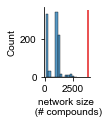

In [100]:
sns.displot(network_sizes,height=1.5,aspect=1)
plt.vlines(3806,0,350,colors=cmap[0])
plt.xlabel("network size \n (# compounds)")
plt.savefig("figs/permutationTest.EukDepletion.small.svg")